In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import bct
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Setup

In [2]:
# change defaults to be less ugly
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [3]:
files = ['test','training','validation']
# Keep track of nodes that are in the matrices
tracked_nodes = [1] * 200

dataframes = {}
for file in files:
    df = pd.read_csv(f'SupportingInfo/phenotypic_{file}.csv')
    dataframes[file] = df

# Metadata for all subjects
combined = pd.concat(dataframes.values(), ignore_index=True)
print(combined)

        Subj Sex    Age       DX  WISC_FSIQ  Edinburgh_Handedness
0    sub-004   F   9.22      HFA      115.0                  1.00
1    sub-006   F   9.99      HFA      115.0                  1.00
2    sub-007   M   8.20      HFA       97.0                  1.00
3    sub-008   M   8.46      HFA      114.0                  0.89
4    sub-010   M  10.66      HFA       90.0                  1.00
..       ...  ..    ...      ...        ...                   ...
452  sub-482   M   9.24     ADHD      115.0                  1.00
453  sub-491   M  11.98     ADHD      112.0                  1.00
454  sub-494   F  10.62  Control      118.0                  0.88
455  sub-506   F   9.95  Control      111.0                  0.90
456  sub-517   M   8.53  Control      111.0                  1.00

[457 rows x 6 columns]


## Diagnosis - split 
Create metadata df for each group

In [4]:
# Split the combined dataframe by DX column
dx_groups = combined.groupby('DX')

for dx, group in dx_groups:
    print(f"DX = {dx}: {len(group)} subjects")

# DF for each DX group
dx_dataframes = {}
for dx, group in dx_groups:
    print(dx)
    print(group)
    dx_dataframes[dx] = group.reset_index(drop=True)

DX = ADHD: 148 subjects
DX = Control: 228 subjects
DX = HFA: 81 subjects
ADHD
        Subj Sex    Age    DX  WISC_FSIQ  Edinburgh_Handedness
39   sub-066   F   9.52  ADHD      122.0                  0.67
55   sub-115   M  11.04  ADHD      112.0                  1.00
59   sub-128   F  12.31  ADHD       78.0                  0.81
61   sub-133   M   9.50  ADHD      102.0                  1.00
157  sub-309   M  12.31  ADHD       88.0                  1.00
..       ...  ..    ...   ...        ...                   ...
445  sub-427   M   8.93  ADHD      117.0                  1.00
448  sub-439   M   8.84  ADHD      105.0                  0.82
451  sub-470   F  11.73  ADHD       84.0                  1.00
452  sub-482   M   9.24  ADHD      115.0                  1.00
453  sub-491   M  11.98  ADHD      112.0                  1.00

[148 rows x 6 columns]
Control
        Subj Sex    Age       DX  WISC_FSIQ  Edinburgh_Handedness
33   sub-042   M  11.77  Control      117.0                  1.00
34

# Analyse demographics

## Sex by diagnosis

In [5]:
sex_dx_df = pd.DataFrame(index=['M','F'])
for dx, df in dx_dataframes.items():
    n_males = sum([1 for x in df['Sex'] if str(x).lower() == 'm'])
    n_females = df.index.size - n_males
    print(f"DX = {dx}, Male = {n_males}, Female = {n_females}   total: {df.index.size}")

DX = ADHD, Male = 105, Female = 43   total: 148
DX = Control, Male = 157, Female = 71   total: 228
DX = HFA, Male = 64, Female = 17   total: 81


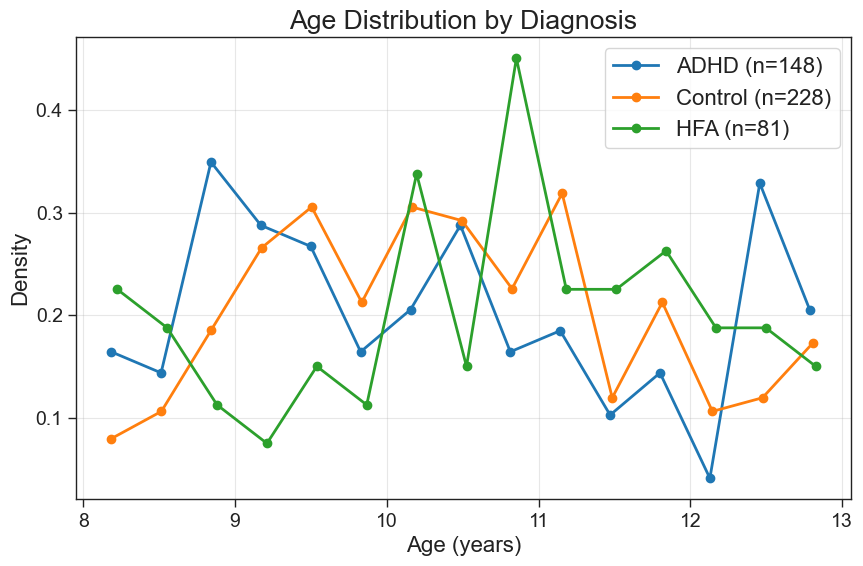

Age Statistics by Diagnosis:
ADHD: Mean=10.34, Std=1.42, Min=8.02, Max=12.95
Control: Mean=10.45, Std=1.23, Min=8.02, Max=12.97
HFA: Mean=10.66, Std=1.35, Min=8.06, Max=12.99


In [6]:
plt.figure(figsize=(10, 6))

# Create age distribution plot for each diagnosis using lines
for dx, df in dx_dataframes.items():
    # Create histogram data
    counts, bins = np.histogram(df['Age'], bins=15, density=True)



    # Calculate bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot as line
    plt.plot(bin_centers, counts, marker='o', linewidth=2, label=f'{dx} (n={len(df)})')

plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.title('Age Distribution by Diagnosis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("Age Statistics by Diagnosis:")
for dx, df in dx_dataframes.items():
    print(f"{dx}: Mean={df['Age'].mean():.2f}, Std={df['Age'].std():.2f}, Min={df['Age'].min():.2f}, Max={df['Age'].max():.2f}")

## Age by diagnosis

In [7]:
# Create age counts by diagnosis
age_counts_by_dx = {}
for dx, df in dx_dataframes.items():
    rounded_ages = [round(age) for age in df['Age']]
    age_counts = pd.Series(rounded_ages).value_counts().sort_index()
    age_counts_by_dx[dx] = age_counts

# df with all ages and diagnoses
rounded_ages = np.array([round(age) for age in combined['Age']])
all_ages = sorted(np.unique(rounded_ages))
age_dx_df = pd.DataFrame(index=all_ages)
for dx in dx_dataframes.keys():
    age_dx_df[dx] = 0
    for age in all_ages:
        if age in age_counts_by_dx[dx]:
            age_dx_df.loc[age, dx] = age_counts_by_dx[dx][age]

# Save to CSV
age_dx_df.to_csv('age_diagnosis_counts.csv')
print(f"CSV saved with {len(age_dx_df)} age groups and {len(dx_dataframes)} diagnoses")

CSV saved with 6 age groups and 3 diagnoses


# Create Matrices

## Create Functions

In [8]:
def get_adjacency_matrix(timeseries_data, fisherZ=False, verbose = False):
    """ 
    Given timeseries data (ROIs x Timepoints), compute the adjacency matrix using Pearson correlation.
    Parameters:
    - timeseries_data: 2D array-like, shape (n_ROIs, n_timepoints)
        Time series data for each ROI.
    - fisherZ: bool, optional
        If True, apply Fisher Z-transformation to the correlation coefficients.
    Returns:
    - adj_matrix: 2D numpy array, shape (n_ROIs, n_ROIs)
        The computed adjacency matrix.
    """
    arr = np.asarray(timeseries_data)
    # Z-score each ROI across time ?
    # ave_timeseries = timeseries_data.mean(axis=1)
    # zscored_timeseries = (timeseries_data - ave_timeseries) / timeseries_data.std(axis=0)
    # correlation_matrix = zscored_timeseries.T @ zscored_timeseries
    # adj_matrix = np.corrcoef(zscored_timeseries, rowvar=False)
    # t_arr = arr.T
    adj_matrix = np.corrcoef(arr, rowvar=True)
    np.fill_diagonal(adj_matrix, 0.0)  # Remove self-loops!
    if fisherZ:
        adj_matrix = np.arctanh(np.clip(adj_matrix, -0.9999, 0.9999))
    if verbose:        
        print(f"Input shape: {arr.shape}")
        print(f"Output shape: {adj_matrix.shape}")
    return adj_matrix

In [9]:
def find_nan_rows(matrix):
    """
    Find all rows in the adjacency matrix that contain NaN values.
    
    Parameters:
    matrix (numpy.ndarray): The adjacency matrix to check
    
    Returns:
    numpy.ndarray: Array of row indices that contain NaN values
    """
    nan_rows = np.where(np.isnan(matrix).any(axis=1))[0]
    return nan_rows


def find_zero_rows(matrix): #whole row
    """
    Find all rows in the adjacency matrix that are entirely zeros.
    
    Parameters:
    matrix (numpy.ndarray): The adjacency matrix to check
    
    Returns:
    numpy.ndarray: Array of row indices that are entirely zeros
    """
    zero_rows = np.where(np.all(matrix == 0, axis=1))[0]
    return zero_rows

In [10]:
import os
import pickle


def remove_nodes_from_all_networks(nodes):
    nodes = sorted(set(nodes), reverse=True)
    matrices = os.listdir('networkx_graphs/')
    for matrix in matrices:
        # for node in nodes:
        #     # Adjust for previously removed nodes
        #     rel_zeros = tracked_nodes[:node].count(0)
        #     node = node - rel_zeros
        #     # Remove node if still tracked
        #     if tracked_nodes[node]:
        #         tracked_nodes[node] = 0
        #         mat = np.load(f'/{matrix}')
        #         mat = np.delete(mat, node, axis=0)
        #         mat = np.delete(mat, node, axis=1)
        #         np.save(f'adj_matrices/{matrix}', mat)
        with open(f'networkx_graphs/{matrix}', 'rb') as f:
            graph = pickle.load(f)
        for node in nodes:
            if node in graph:
                graph.remove_node(node)
                tracked_nodes[node] = 0
        with open(f'networkx_graphs/{matrix}', 'wb') as f:
            pickle.dump(graph, f, pickle.HIGHEST_PROTOCOL)


## Apply Functions, Save files

In [11]:
import os
import pickle

def create_adj_matrices(files):
    global tracked_nodes
    nan = {}
    sparse = {}
    tracked_nodes = [1] * 200
    if not os.path.exists('adj_matrices'):
        os.makedirs('adj_matrices')
    if not os.path.exists('networkx_graphs'):
        os.makedirs('networkx_graphs')
    for folder in files:
        subjects = os.listdir(folder)
        for subject in subjects:
            # Read raw timeseries data
            timeseries = pd.read_csv(f'{folder}/{subject}/timeseries_cc200.csv')
            
            # Find problematic rows
            nans = find_nan_rows(timeseries)
            spars = find_zero_rows(timeseries)
            if len(nans) > 0:
                nan[subject] = nans
            if len(spars) > 0:
                sparse[subject] = spars
                
            # Compute adjacency matrix
            matrix = get_adjacency_matrix(timeseries)
            
            # Save adjacency matrix
            np.save(f'adj_matrices/{subject}_am.npy', matrix)
            
            # Create networkx graph and save
            graph = nx.from_numpy_array(matrix)
            with open(f'networkx_graphs/{subject}_graph.gpickle', 'wb') as f:
                pickle.dump(graph, f, pickle.HIGHEST_PROTOCOL)
            # print(f'Subject: {subject}, Adjacency Matrix Shape: {matrix.shape}')
    return nan, sparse
            

In [12]:
nan, sparse = create_adj_matrices(files)

c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Examine Problem rows

In [13]:
# Display stats about NaN and sparse rows
print("NaN Statistics:")
if nan:
    nan_lengths = [len(indices) for indices in nan.values()]
    nan_df = pd.DataFrame(nan_lengths, columns=['NaN Row Count'], index=nan.keys())
    # unique_lengths, counts = np.unique(nan_lengths, return_counts=True)
    # Sort by count (descending) and get top 4
    # sorted_indices = np.argsort(counts)[::-1]
    nan_df = nan_df.sort_values(by='NaN Row Count', ascending=False)
    top_4_nan = nan_df.head(4)
    print(f"Top 4 most common NaN row counts:")
    for index, row in top_4_nan.iterrows():
        print(f"  {row['NaN Row Count']} NaN rows: {index} subjects")
    print(f"Total subjects with NaN rows: {len(nan)}")
else:
    print("No subjects with NaN rows found")

print("\nSparse Statistics:")
if sparse:
    sparse_lengths = [len(indices) for indices in sparse.values()]
    sparse_df = pd.DataFrame(sparse_lengths, columns=['Sparse Row Count'], index=sparse.keys())
    # unique_lengths, counts = np.unique(sparse_lengths, return_counts=True)
    # Sort by count (descending) and get top 4
    # sorted_indices = np.argsort(counts)[::-1]
    # top_4_sparse = [(unique_lengths[i], counts[i]) for i in sorted_indices[:4]]
    sparse_df = sparse_df.sort_values(by='Sparse Row Count', ascending=False)
    top_4_sparse = sparse_df.head(4)
    print(f"Top 4 most common zero row counts:")
    for index, row in top_4_sparse.iterrows():
        print(f"  {row['Sparse Row Count']} zero rows: {index} subjects")
    print(f"Total subjects with zero rows: {len(sparse)}")
else:
    print("No subjects with zero rows found")

NaN Statistics:
No subjects with NaN rows found

Sparse Statistics:
Top 4 most common zero row counts:
  1 zero rows: sub-236 subjects
Total subjects with zero rows: 1


In [14]:
print(f"Subject {list(sparse.keys())[0]} has zero row at node: {sparse[list(sparse.keys())[0]][0]}")

Subject sub-236 has zero row at node: 185


In [15]:
# deal with nodes with no info
# remove_nodes([sparse[list(sparse.keys())[0]][0]])
remove_nodes_from_all_networks([sparse[list(sparse.keys())[0]][0]])

Investigate NaNs and zeroes across a whole column/row. Need to remove these...

Mindful. Need to balance
1. One person missing a lot (30%) of their network? Lose that subject.
2. If parcellation x is bad/missing in say, 5% of the population, you want to remove that region from everyone so htat your regions are all the same size.

When balancing these, subjects matter more than regions. Try to save as many subjects as possible.

Connectome will have self-loops. Remove self-loops!

In [16]:
analysisdf = pd.DataFrame(combined['Subj'].copy(), columns=['Subj'])

In [17]:
analysisdf

,Subj
0,sub-004
1,sub-006
2,sub-007
3,sub-008
4,sub-010
...,...
452,sub-482
453,sub-491
454,sub-494
455,sub-506


# Thresholding

## Thresholding min where everyone is connected

In [18]:
# def min_threshold(graph: nx.Graph, test_range = range(30,10,-1)):
#     best_thresh = None
#     best_graph = None
#     n_edges = graph.number_of_edges()
#     n_nodes = graph.number_of_nodes()
#     max_possible_edges = n_nodes * (n_nodes - 1) / 2
#     # current_density = n_edges / max_possible_edges
#     # print(f"Testing range: {test_range}")
#     i=0
#     while best_thresh is None and i < len(test_range):
#         thresh = test_range[i]
#         # print(f"i={i}, Testing threshold: {thresh}")
#         density = thresh / 100.0
#         target = int(density * max_possible_edges)
#         # print(f"Target density: {density}")
#         # print(f"Target edges: {target}")
#         # Take absolute value of edge weights for proper thresholding
#         edges_with_abs_weights = []
#         for u, v, data in graph.edges(data=True):
#             abs_weight = abs(data['weight'])
#             edges_with_abs_weights.append((u, v, {'weight': abs_weight}))
#         # Create new graph with absolute weight values
#         abs_graph = nx.Graph()
#         abs_graph.add_nodes_from(graph.nodes(data=True))
#         abs_graph.add_edges_from(edges_with_abs_weights)
#         # Sort edges by weight
#         edges = sorted(abs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
#         # Sort edges by weight
#         edges = sorted(graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
        
#         # Create new graph with top edges
#         threshed_g = nx.Graph()
#         threshed_g.add_nodes_from(graph.nodes(data=True))
        
#         # edges_to_add = min(target, n_edges)
#         threshed_g.add_edges_from(edges[:target]) # Automatically handles case where target > n_edges ?
        
#         # new_n_edges = threshed_g.number_of_edges()
        
#         if nx.is_connected(threshed_g):
#             best_graph = threshed_g
#         else:
#             # If not connected, keep previous threshold
#             if i >0:
#                 best_thresh = test_range[i-1] 
#             else: 
#                 print(f"Graph is not connected at the highest threshold.")
#                 return -1
#             # print(f"Graph at threshold {thresh} is not connected ({new_n_edges} edges).")
#             print(f"Best connected graph at threshold {best_thresh} with {best_graph.number_of_edges()} edges. ")
#         i += 1

#     return best_thresh #, best_graph

In [19]:
def topx_threshold(graph: nx.Graph, thresh: 10, subject=None, save=False):
    '''
    Threshold the graph to keep only the top x% of edges by weight.
    Returns the thresholded graph.
    '''
    # Calculate number of edges to keep
    n_edges = graph.number_of_edges()
    n_nodes = graph.number_of_nodes()
    max_possible_edges = n_nodes * (n_nodes - 1) / 2
    target = int(thresh * max_possible_edges / 100)
    n_neg_edges = len([edge for edge in graph.edges(data=True) if edge[2]['weight'] < 0])
    # print(f"Total edges: {n_edges}, Negative edges: {n_neg_edges}, Target edges to keep: {target}")
    # Take absolute value of edge weights
    
    # Sort ALL edges by absolute weight (but keep original weight info)
    edges_with_abs = [(u, v, data['weight'], abs(data['weight'])) 
                       for u, v, data in graph.edges(data=True)]
    
    # Sort by absolute weight (descending)
    edges_with_abs.sort(key=lambda x: x[3], reverse=True)
    
    cutoff = edges_with_abs[target-1][3]
    
    # Create new graph with all nodes and top edges
    threshed_g = nx.Graph()
    threshed_g.add_nodes_from(graph.nodes(data=True))
    threshed_g.add_edges_from(graph.edges(data=True))
    n=0
    lowest_edge = 0
    for u, v, orig_weight, abs_weight in edges_with_abs:
        if abs_weight < cutoff:
            threshed_g.remove_edge(u, v)
            if orig_weight < 0:
                n += 1
            if orig_weight < lowest_edge:
                lowest_edge = orig_weight
    # print(f"Removed {n} negative edges below cutoff {cutoff}, lowest removed edge weight: {lowest_edge}")
            
    # print(f"Thresholded graph negative edges: {n_thresh_neg_edges}")
    
    if save:
        if not os.path.exists('thresholded_graphs'):
            os.makedirs('thresholded_graphs')
        with open(f'thresholded_graphs/{subject}_thresholded_graph_{thresh}.gpickle', 'wb') as f:
             pickle.dump(threshed_g, f, pickle.HIGHEST_PROTOCOL)
    return threshed_g

In [20]:
def min_threshold(graph: nx.Graph, test_range = range(30,10,-1)):
    ''' 
    Determine the minimum threshold percentage at which the graph remains connected.
    Parameters:
    - graph: networkx.Graph
        The input graph with weighted edges.
    - test_range: iterable of int, optional
        The range of threshold percentages to test (default: range(30,10,-1)).
    Returns:
    - best_thresh: int
        The highest threshold percentage at which the graph remains connected.
    '''
    best_thresh = -1
    best_graph = None
    negative_edges_thresh = 0
    # n_edges = graph.number_of_edges()
    # n_nodes = graph.number_of_nodes()
    # max_possible_edges = n_nodes * (n_nodes - 1) / 2
    
    for i, thresh in enumerate(test_range):
        # density = thresh / 100.0
        # target = int(density * max_possible_edges)
        
        # # Take absolute value of edge weights for proper thresholding
        # edges_with_abs_weights = []
        # for u, v, data in graph.edges(data=True):
        #     abs_weight = abs(data['weight'])
        #     edges_with_abs_weights.append((u, v, {'weight': abs_weight}))
        
        # # Create new graph with absolute weight values
        # abs_graph = nx.Graph()
        # abs_graph.add_nodes_from(graph.nodes(data=True))
        # abs_graph.add_edges_from(edges_with_abs_weights)
        
        # # Sort edges by absolute weight
        # edges = sorted(abs_graph.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)
        
        # # Create new graph with top edges
        # threshed_g = nx.Graph()
        # threshed_g.add_nodes_from(graph.nodes(data=True))
        # threshed_g.add_edges_from(edges[:target])
        threshed_g = topx_threshold(graph, thresh)
        
        if nx.is_connected(threshed_g):
            # Still connected, update best and continue
            best_thresh = thresh
            best_graph = threshed_g
        else: pass
            # If not connected, check for negative edges
        
        has_negative = any(data['weight'] < 0 for u, v, data in threshed_g.edges(data=True))
        if has_negative:
            negative_edges_thresh = thresh
        else:
            # Just became disconnected, return previous threshold
            if best_thresh is not None:
                # print(f"Best connected graph at threshold {best_thresh}% with {best_graph.number_of_edges()} edges.")
                return best_thresh, best_graph, negative_edges_thresh
            else:
                # print(f"Graph is not connected even at the highest threshold ({test_range[0]}%).")
                return -1, None, negative_edges_thresh
    return best_thresh, best_graph, negative_edges_thresh

Find the minimum threshold for every subject, then determine the highest across all.

### Get all thresholds

In [21]:
cutoff = 10 # the max number to test in the first iteration of threshold finding
thresholds = {}
neg_edge_thresholds = {}

In [22]:
for i, subject in enumerate(analysisdf['Subj']):
    if thresholds.get(subject) is not None and thresholds.get(subject) != -1: # already have a valid threshold, lets me rerun cell.
        continue
    print(f"Processing subject {i+1}/{len(analysisdf)}: {subject}")
    # matrix = np.load(f'adj_matrices/{subject}_am.npy')
    with open(f'networkx_graphs/{subject}_graph.gpickle', 'rb') as f:
        G = pickle.load(f)
    # matrix = nx.to_numpy_array(G)
    # Threshold the matrix
    # print(f"Processing subject {subject}, {matrix.shape}")
    s_cutoff = cutoff
    threshold, best_graph, negative_edges_thresh = min_threshold(G, range(s_cutoff,0,-1))
    while (threshold == -1 or negative_edges_thresh==0) and s_cutoff < 100:
        s_cutoff += 10
        threshold, best_graph, negative_edges_thresh = min_threshold(G, range(s_cutoff,0,-1))
        
    if threshold == None:
        print(f"Subject {subject} returned None instead of -1")
    else:
        print(f"Subject {subject} minimum connected threshold: {threshold}%")
    # thresholded_graphs[subject] = (threshold, G)
    thresholds[subject] = threshold
    neg_edge_thresholds[subject] = negative_edges_thresh


Processing subject 1/457: sub-004
Subject sub-004 minimum connected threshold: 18%
Processing subject 2/457: sub-006
Subject sub-006 minimum connected threshold: 18%
Processing subject 3/457: sub-007
Subject sub-007 minimum connected threshold: 21%
Processing subject 4/457: sub-008
Subject sub-008 minimum connected threshold: 26%
Processing subject 5/457: sub-010
Subject sub-010 minimum connected threshold: 22%
Processing subject 6/457: sub-011
Subject sub-011 minimum connected threshold: 18%
Processing subject 7/457: sub-015
Subject sub-015 minimum connected threshold: 39%
Processing subject 8/457: sub-016
Subject sub-016 minimum connected threshold: 29%
Processing subject 9/457: sub-017
Subject sub-017 minimum connected threshold: 52%
Processing subject 10/457: sub-018
Subject sub-018 minimum connected threshold: 12%
Processing subject 11/457: sub-019
Subject sub-019 minimum connected threshold: 14%
Processing subject 12/457: sub-020
Subject sub-020 minimum connected threshold: 23%
P

In [23]:
threshold_df = pd.DataFrame(list(thresholds.items()), columns = ['Subj','Thresh'])
threshold_df = threshold_df.sort_values(by='Thresh', ascending = False, ignore_index=True)
threshold_df

,Subj,Thresh
0,sub-037,94
1,sub-321,93
2,sub-379,91
3,sub-362,91
4,sub-343,91
...,...,...
452,sub-137,6
453,sub-273,6
454,sub-257,6
455,sub-440,6


In [24]:
print(len(analysisdf))

457


In [25]:
neg_threshold_df = pd.DataFrame(list(neg_edge_thresholds.items()), columns = ['Subj','Neg_Thresh'])
neg_threshold_df = neg_threshold_df.sort_values(by='Neg_Thresh', ascending = False, ignore_index=True)
neg_threshold_df

,Subj,Neg_Thresh
0,sub-037,95
1,sub-321,94
2,sub-362,92
3,sub-379,92
4,sub-343,92
...,...,...
452,sub-031,1
453,sub-492,1
454,sub-027,1
455,sub-303,1


In [26]:
# The highest threshold across all subjects
threshold = threshold_df.iloc[0]['Thresh']
print(f"Maximum minimum connected threshold across all subjects: {threshold}%")

Maximum minimum connected threshold across all subjects: 94%


## Investigate High Thresholds
Get all the thresholds over max

### Get Disconnected Components

In [27]:
def get_disconnected_comp(density, subjects):
    ''' 
    Examines every subject in the subject list and returns the components that are disconnected from the main network at the given density.
    Parameters:
    - density: float
        The density threshold (as a percentage, e.g., 50 for 50%)
    - subjects: list of str
        List of subject identifiers to analyze.
    Returns:
    - subject_disc_nodes: dict
    
    '''
    subject_disc_nodes = {}
    for subject in subjects:
        # graph = nx.from_numpy_array(np.load(f'adj_matrices/{subject}_am.npy'))
        with open(f'networkx_graphs/{subject}_graph.gpickle', 'rb') as f:
            graph = pickle.load(f)
            
        threshed_g = topx_threshold(graph, density)
        
        if nx.is_connected(threshed_g):
            print(f"Subject {subject} is connected at {density}% threshold.")
            continue

        # Find the disconnected nodes and smaller components
        components = list(nx.connected_components(threshed_g))
        sorted_comp = sorted(components, key=len, reverse=True)
        sorted_comp = sorted_comp[1:]  # Exclude largest component
        
        sorted_comp_sizes = [len(comp) for comp in sorted_comp]
        print(f"Subject {subject} at {density}% threshold:")
        print(f" Components: ")
        for i, comp in enumerate(sorted_comp):
            print(f"   Component {i+1}: {comp}")
        print(f"  Component sizes: {sorted_comp_sizes}")
        subject_disc_nodes[subject] = sorted_comp
    return subject_disc_nodes

In [28]:
inclusion_cutoff = 30
included_subjects = [(subject, threshold) for subject, threshold in thresholds.items() if threshold < inclusion_cutoff]
subjects_over_max = included_subjects

In [29]:
print(len(subjects_over_max))

350


In [30]:
# excluded_nodes =[node for node, count in n_nodes.items() if count > 2]
# excluded_nodes = sorted(excluded_nodes, reverse=True) # put in descending order for easier removal from the matrix
# remove_nodes(excluded_nodes)

### Get final set of thresholded, included graphs

In [31]:
thresholded_graphs = {}
negative_counts = {}
print(f"\nVerifying all subjects are connected at final threshold = {inclusion_cutoff}%:")

for subject, _ in included_subjects:
    with open(f'networkx_graphs/{subject}_graph.gpickle', 'rb') as f:
        graph = pickle.load(f)
    # Threshold the matrix
    # print(f"Processing subject {subject}")
    G = topx_threshold(graph, inclusion_cutoff, subject=subject, save=True)
    n_thresh_neg_edges = len([edge for edge in G.edges(data=True) if edge[2]['weight'] < 0])
    thresholded_graphs[subject] = G
    negative_counts[subject] = n_thresh_neg_edges
    if not nx.is_connected(G):
        print(f"Subject {subject} is not connected.")
        break


Verifying all subjects are connected at final threshold = 30%:


In [32]:
print(f"Average number of negative edges across all subjects at {inclusion_cutoff}% threshold: {np.mean(list(negative_counts.values())):.2f}")

Average number of negative edges across all subjects at 30% threshold: 282.64


# Group Average Matrix

In [114]:
ave_matrices = {}
included_subj_list = [subject for subject, _ in included_subjects]
for dx, df in dx_dataframes.items():
    # Get all subject matrices in this diagnosis
    # subjects = included_subjects
    matrices = []
    for subject in df['Subj']:
        if subject in included_subj_list:
            # Load their adjacency matrix
            with open(f'thresholded_graphs/{subject}_thresholded_graph_{inclusion_cutoff}.gpickle', 'rb') as f:
                graph = pickle.load(f)
            matrix = nx.to_numpy_array(graph)
            # print(f"Matrix shape: {matrix.shape}")
            matrices.append(matrix)
        
    np_matrices = np.array(matrices)
    
    # count subjects with each edge
    edge_counts = (np_matrices != 0).astype(int)
    edge_consistency = edge_counts.mean(axis=0) # fraction of subjects with each edge
    
    # Flatten all matrices to average
    ave_matrix = np.mean(np_matrices, axis=0)
    
    print(f"Number of negative edges before thresholding: {np.sum(ave_matrix < 0) // 2}")
    
    # # Keep edges present in at least x%
    # ave_edge_thresh = 0.5
    # ave_matrix[edge_consistency < ave_edge_thresh] = 0
    
    g = nx.from_numpy_array(ave_matrix)
    n_edges = nx.number_of_edges(g)
    ave_edge_thresh = 0.5
    edges = sorted(list(g.edges(data=True)), key=lambda x: abs(x[2]['weight']), reverse=True)
    n_keep = int(ave_edge_thresh * n_edges)
    edges_to_remove = edges[n_keep:]
    print(f"Removing {len(edges_to_remove)} edges below threshold of {ave_edge_thresh*100:.0f}% strength")
    for u, v, data in edges_to_remove:
        g.remove_edge(u, v)
    
    # neg_edges = np.sum(ave_matrix < 0) // 2 
     
    # print(f"{dx}: {len(matrices)} subjects, "
    #     f"{np.sum(ave_matrix != 0) // 2} edges in average matrix - {neg_edges} negative edges "
    #     f"(consistency >= {ave_edge_thresh*100:.0f}%)")

    
    # ave_matrices[dx] = nx.from_numpy_array(ave_matrix)
    
    neg_edges = len([edge for edge in g.edges(data=True) if edge[2]['weight'] < 0])
    print(f"{dx}: {len(matrices)} subjects, "
        f"{nx.number_of_edges(g)} edges in average matrix - {neg_edges} negative edges "
        f"(strength >= {ave_edge_thresh*100:.0f}%)")
    print("")
    
    ave_matrices[dx] = g

Number of negative edges before thresholding: 601
Removing 9752 edges below threshold of 50% strength
ADHD: 108 subjects, 9751 edges in average matrix - 2 negative edges (strength >= 50%)

Number of negative edges before thresholding: 888
Removing 9752 edges below threshold of 50% strength
Control: 179 subjects, 9751 edges in average matrix - 7 negative edges (strength >= 50%)

Number of negative edges before thresholding: 710
Removing 9749 edges below threshold of 50% strength
HFA: 63 subjects, 9748 edges in average matrix - 2 negative edges (strength >= 50%)



In [115]:
# ave_matrices = {}
included_subj_list = [subject for subject, _ in included_subjects]
for dx, df in dx_dataframes.items():
    # Get all subject matrices in this diagnosis
    # subjects = included_subjects
    matrices = []
    for subject in df['Subj']:
        if subject in included_subj_list:
            # Load their adjacency matrix
            with open(f'thresholded_graphs/{subject}_thresholded_graph_{inclusion_cutoff}.gpickle', 'rb') as f:
                graph = pickle.load(f)
            matrix = nx.to_numpy_array(graph)
            # print(f"Matrix shape: {matrix.shape}")
            matrices.append(matrix)
        
    np_matrices = np.array(matrices)
    
    # count subjects with each edge
    edge_counts = (np_matrices != 0).astype(int)
    edge_consistency = edge_counts.mean(axis=0) # fraction of subjects with each edge
    
    # Flatten all matrices to average
    ave_matrix = np.mean(np_matrices, axis=0)
    
    print(f"Number of negative edges before consistency thresholding: {np.sum(ave_matrix < 0) // 2}")
    
    # # Keep edges present in at least x%
    ave_edge_thresh = 0.5
    ave_matrix[edge_consistency < ave_edge_thresh] = 0
    
    # g = nx.from_numpy_array(ave_matrix)
    # n_edges = nx.number_of_edges(g)
    # ave_edge_thresh = 0.5
    # edges = sorted(list(g.edges(data=True)), key=lambda x: abs(x[2]['weight']), reverse=True)
    # n_keep = int(ave_edge_thresh * n_edges)
    # edges_to_remove = edges[n_keep:]
    # print(f"Removing {len(edges_to_remove)} edges below threshold of {ave_edge_thresh*100:.0f}% strength")
    # for u, v, data in edges_to_remove:
    #     g.remove_edge(u, v)
    
    neg_edges = np.sum(ave_matrix < 0) // 2 
     
    print(f"{dx}: {len(matrices)} subjects, "
        f"{np.sum(ave_matrix != 0) // 2} edges in average matrix - {neg_edges} negative edges "
        f"(consistency >= {ave_edge_thresh*100:.0f}%)")

    
    # ave_matrices[dx] = nx.from_numpy_array(ave_matrix)
    
    neg_edges = len([edge for edge in g.edges(data=True) if edge[2]['weight'] < 0])
    print(f"{dx}: {len(matrices)} subjects, "
        f"{nx.number_of_edges(g)} edges in average matrix - {neg_edges} negative edges "
        f"(strength >= {ave_edge_thresh*100:.0f}%)")
    print("")
    
    # ave_matrices[dx] = g

Number of negative edges before consistency thresholding: 601
ADHD: 108 subjects, 3345 edges in average matrix - 0 negative edges (consistency >= 50%)
ADHD: 108 subjects, 9748 edges in average matrix - 2 negative edges (strength >= 50%)

Number of negative edges before consistency thresholding: 888
Control: 179 subjects, 3111 edges in average matrix - 0 negative edges (consistency >= 50%)
Control: 179 subjects, 9748 edges in average matrix - 2 negative edges (strength >= 50%)

Number of negative edges before consistency thresholding: 710
HFA: 63 subjects, 3197 edges in average matrix - 0 negative edges (consistency >= 50%)
HFA: 63 subjects, 9748 edges in average matrix - 2 negative edges (strength >= 50%)



In [116]:
print(ave_matrices['ADHD'])

Graph with 198 nodes and 9751 edges


# Degree Distributions

In [35]:
def log_degree_distribution_figure(subject, dx, graph = None): 
    global inclusion_cutoff
    if graph is None:
        with open(f'thresholded_graphs/{subject}_thresholded_graph_{inclusion_cutoff}.gpickle', 'rb') as f:
            G = pickle.load(f)
    else:
        G = graph
    degrees = [d for n, d in G.degree()]
    kmin = np.min(degrees)
    kmax = np.max(degrees)
    
    bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)
    
    plt.Figure(figsize=(8, 6))
    
    # get midpoint of each bin
    log_be = np.log10(bin_edges)
    x = 10 ** ((log_be[:-1] + log_be[1:]) / 2)
    
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.title(f'Log Degree Distribution for {subject} - {dx}')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    # remove right and top boundaries because they're ugly
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.show()

In [36]:
def lin_degree_distribution_figure(subject, dx, graph = None):
    global inclusion_cutoff
    if graph is None: 
        with open(f'thresholded_graphs/{subject}_thresholded_graph_{inclusion_cutoff}.gpickle', 'rb') as f:
            G = pickle.load(f)
    else:
        G = graph
    degrees = [d for n, d in G.degree()]
    kmin = np.min(degrees)
    kmax = np.max(degrees)
    
    # Make the bins
    bin_edges = np.linspace(kmin, kmax, num=10)
    # histogram
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)
    
    plt.Figure(figsize=(8, 6))
    
    # "x" should be midpoint (IN LOG SPACE) of each bin
    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)

    plt.plot(x, density, marker='o', linestyle='none')
    plt.title(f'Linear Degree Distribution for {subject} - {dx}')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    # remove right and top boundaries because they're ugly
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.show()

## Every subject, one graph

In [37]:
# Cell: Analyze degree distributions of every subject
def get_group_dd(subjects, dx):
    global inclusion_cutoff
    plt.figure(figsize=(10, 6))
    for subject in subjects:
        with open(f'thresholded_graphs/{subject}_thresholded_graph_{inclusion_cutoff}.gpickle', 'rb') as f:
            G = pickle.load(f)
        degrees = [d for n, d in G.degree()]
        # print(f"Subject {subject}: Degrees: {degrees}")
        avg_degree = np.mean(degrees)
        kmin = np.min(degrees)
        kmax = np.max(degrees)
        
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)
        density, _ = np.histogram(degrees, bins=bin_edges, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.loglog(bin_centers, density, alpha=0.3, linewidth=0.5)

    plt.xlabel('Degree (k)')
    plt.ylabel('P(k)')
    plt.title(f'Degree Distribution for {dx} Subjects')
    plt.grid(True, alpha=0.3)
    plt.show()

In [38]:
def log_degree_distribution_figure_group(subjects, dx):
    global inclusion_cutoff
    plt.figure(figsize=(10, 6))
    
    # Collect all distributions
    all_densities = []
    all_bin_centers = []
    
    for subject in subjects:
        with open(f'thresholded_graphs/{subject}_thresholded_graph_{inclusion_cutoff}.gpickle', 'rb') as f:
            G = pickle.load(f)
        degrees = [d for n, d in G.degree()]
        kmin = np.min(degrees)
        kmax = np.max(degrees)
        
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)
        density, _ = np.histogram(degrees, bins=bin_edges, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        all_densities.append(density)
        all_bin_centers.append(bin_centers)
    
    # Use common bins, just using the first subject's bins
    common_bins = all_bin_centers[0]
    
    # stats
    densities_array = np.array(all_densities)
    mean_density = np.mean(densities_array, axis=0)
    std_density = np.std(densities_array, axis=0)
    
    # Plot, with shaded std
    plt.loglog(common_bins, mean_density, 'b-', linewidth=2, label=f'Mean (n={len(subjects)})')
    plt.fill_between(common_bins, 
                     mean_density - std_density, 
                     mean_density + std_density,
                     alpha=0.3, color='blue', label='±1 SD')
    
    plt.xlabel('Degree (k)')
    plt.ylabel('P(k)')
    plt.title(f'Degree Distribution for {dx} Subjects')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [39]:
def lin_degree_distribution_figure_group(subjects, dx):
    """
    Plot linear degree distribution with mean and confidence interval for a group.
    """
    global inclusion_cutoff
    plt.figure(figsize=(10, 6))
    
    # from all distributions
    all_densities = []
    all_bin_centers = []
    
    for subject in subjects:
        with open(f'thresholded_graphs/{subject}_thresholded_graph_{inclusion_cutoff}.gpickle', 'rb') as f:
            G = pickle.load(f)
        degrees = [d for n, d in G.degree()]
        kmin = np.min(degrees)
        kmax = np.max(degrees)
        
        # Linear bins
        bin_edges = np.linspace(kmin, kmax, num=15)
        density, _ = np.histogram(degrees, bins=bin_edges, density=True)
        # Centers in log space
        log_be = np.log10(bin_edges)
        bin_centers = 10**((log_be[1:] + log_be[:-1])/2)
        
        all_densities.append(density)
        all_bin_centers.append(bin_centers)
    
    # common bins are just the first subject's bins
    common_bins = all_bin_centers[0]
    
    # stats
    densities_array = np.array(all_densities)
    mean_density = np.mean(densities_array, axis=0)
    std_density = np.std(densities_array, axis=0)
    
    # Plot, with shaded std
    plt.plot(common_bins, mean_density, 'b-', linewidth=2, marker='o', 
             markersize=6, label=f'Mean (n={len(subjects)})')
    plt.fill_between(common_bins, 
                     mean_density - std_density, 
                     mean_density + std_density,
                     alpha=0.3, color='blue', label='±1 SD')
    
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)
    plt.title(f'Linear Degree Distribution for {dx} Subjects')
    plt.legend()
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.grid(True, alpha=0.3)
    plt.show()

Average Degree Distribution for ADHD:


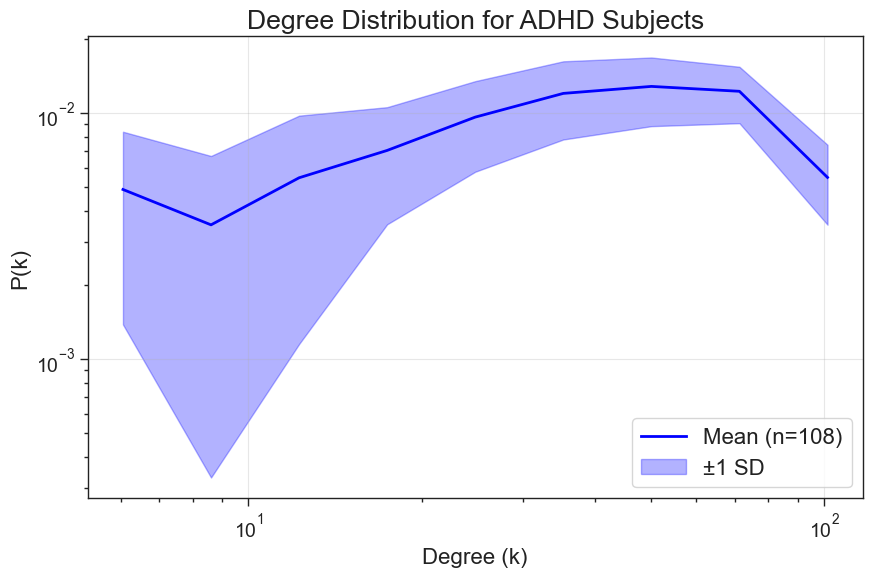

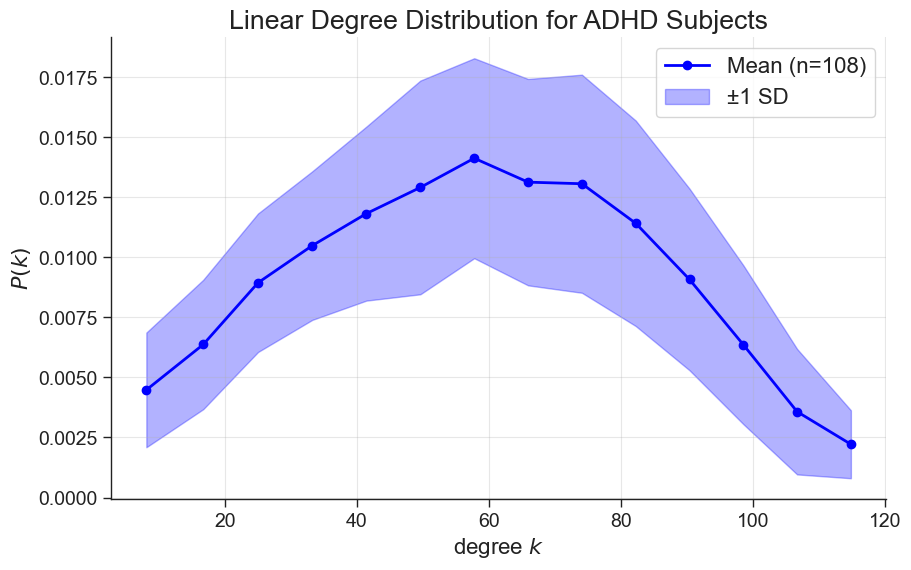

Average Degree Distribution for Control:


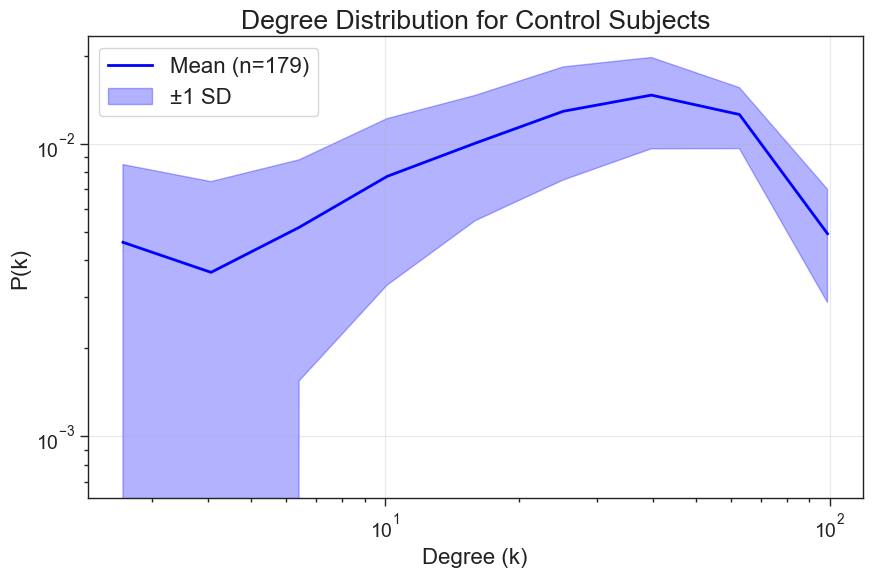

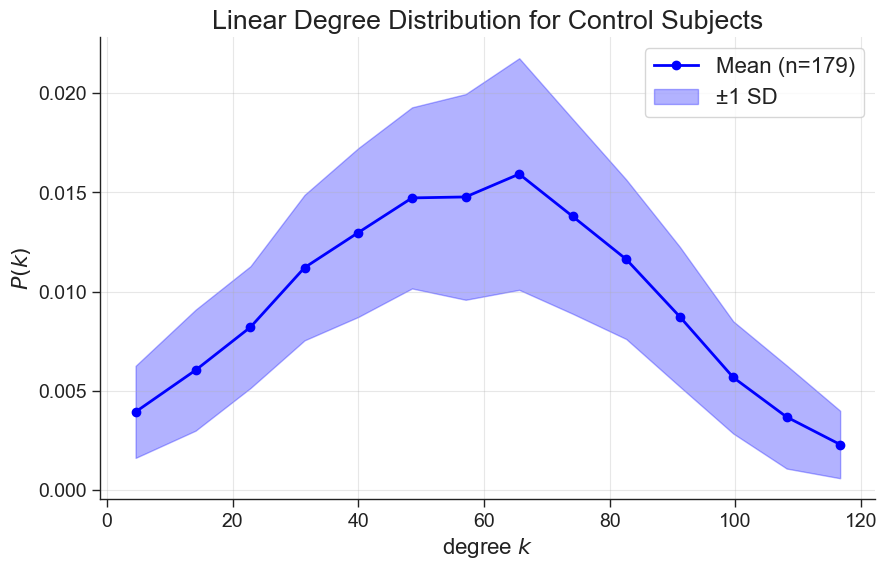

Average Degree Distribution for HFA:


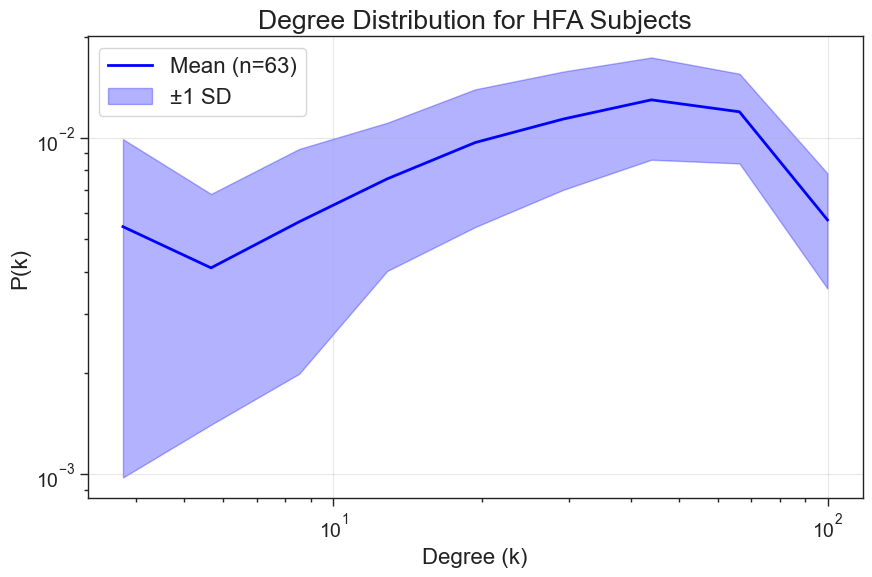

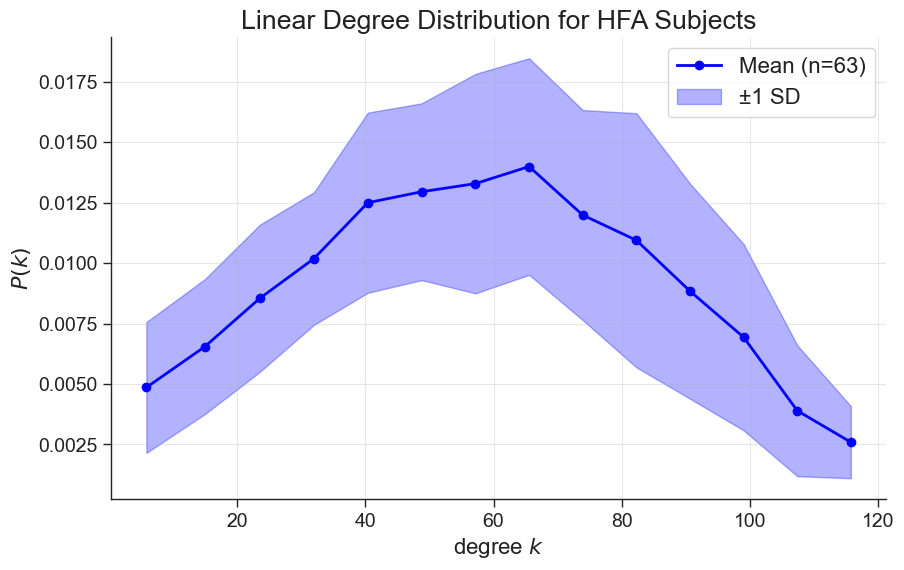

In [40]:
for dx, graph in ave_matrices.items():
    print(f"Average Degree Distribution for {dx}:")
    subjects = [s for s in dx_dataframes[dx]['Subj'] if s in included_subj_list]
    
    # Group-level plots with confidence intervals
    log_degree_distribution_figure_group(subjects, dx)  # Log scale with with confidence intervals
    lin_degree_distribution_figure_group(subjects, dx)  # Linear scale with confidence intervals
    
    # Average matrix plots
    # log_degree_distribution_figure(f'Average_{dx}', dx, graph=graph)
    # lin_degree_distribution_figure(f'Average_{dx}', dx, graph=graph)

In [41]:
analysisdf

,Subj
0,sub-004
1,sub-006
2,sub-007
3,sub-008
4,sub-010
...,...
452,sub-482
453,sub-491
454,sub-494
455,sub-506


## Get Representatives for each diagnosis

In [42]:
subject_list = [tuple[0] for tuple in included_subjects]

In [43]:
# Pick a random subject from each diagnosis and plot their degree distribution

# Representatives for each diagnosis
representatives = {}
for dx, df in dx_dataframes.items():
    random_subject = df.sample(n=1)['Subj'].values[0]
    while random_subject not in subject_list:
        random_subject = df.sample(n=1)['Subj'].values[0]
    print(f"Representative for {dx}: {random_subject}")
    representatives[dx] = random_subject

Representative for ADHD: sub-383
Representative for Control: sub-165
Representative for HFA: sub-206


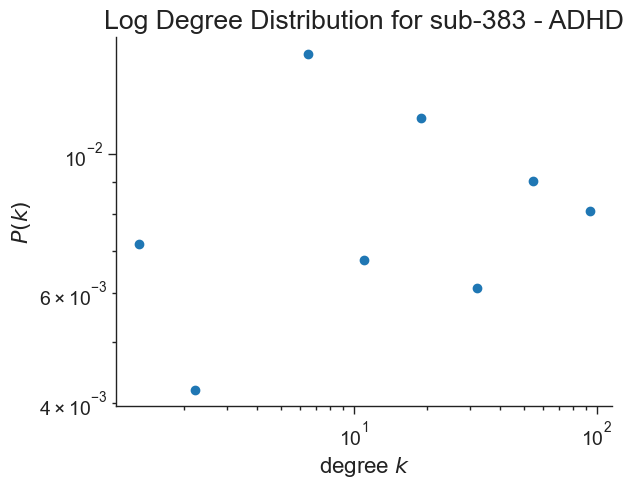

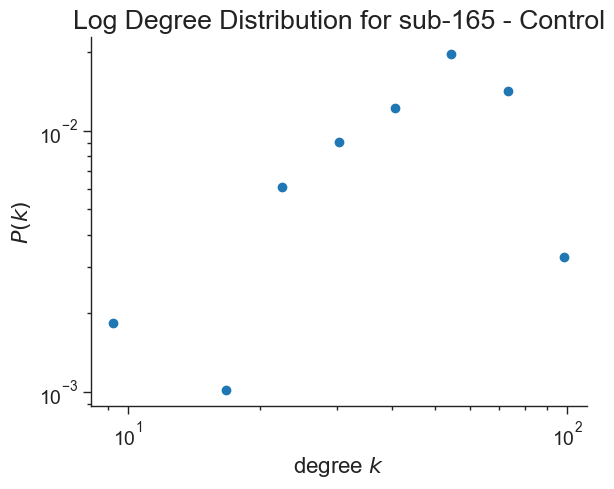

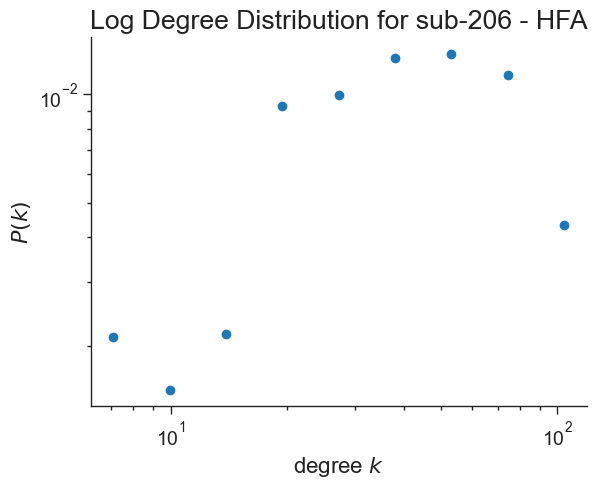

In [44]:
for dx, subject in representatives.items():
    log_degree_distribution_figure(subject, dx)

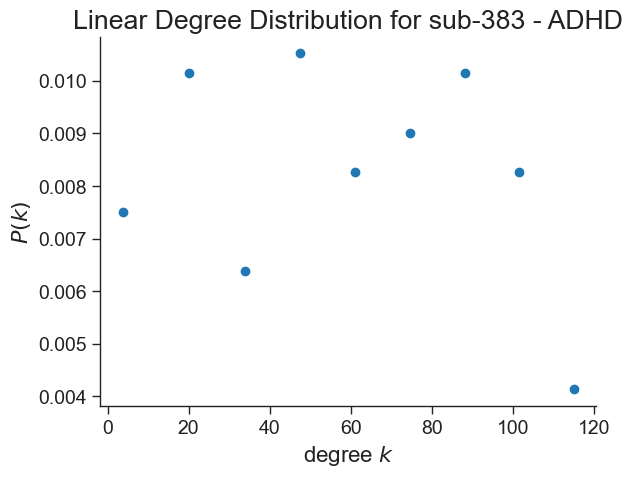

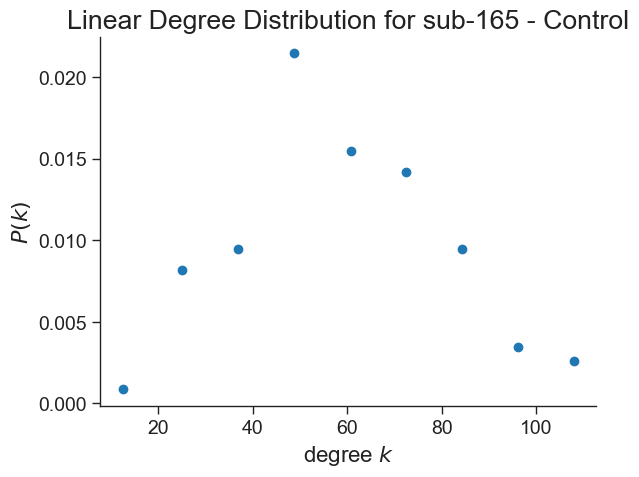

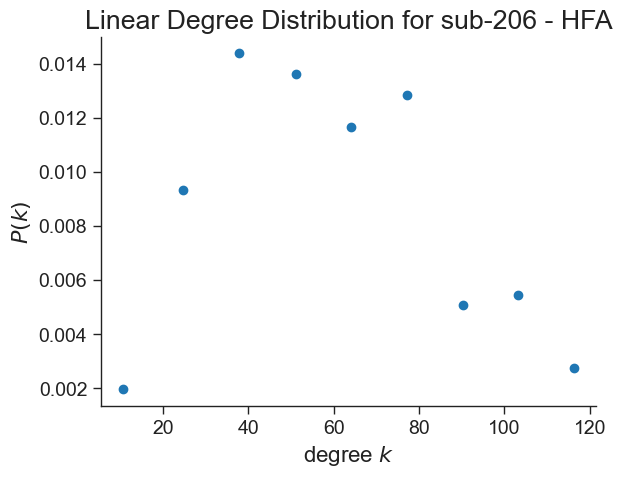

In [45]:
for dx, subject in representatives.items():
    lin_degree_distribution_figure(subject, dx)

In [46]:
print(dx_dataframes['ADHD'])


        Subj Sex    Age    DX  WISC_FSIQ  Edinburgh_Handedness
0    sub-066   F   9.52  ADHD      122.0                  0.67
1    sub-115   M  11.04  ADHD      112.0                  1.00
2    sub-128   F  12.31  ADHD       78.0                  0.81
3    sub-133   M   9.50  ADHD      102.0                  1.00
4    sub-309   M  12.31  ADHD       88.0                  1.00
..       ...  ..    ...   ...        ...                   ...
143  sub-427   M   8.93  ADHD      117.0                  1.00
144  sub-439   M   8.84  ADHD      105.0                  0.82
145  sub-470   F  11.73  ADHD       84.0                  1.00
146  sub-482   M   9.24  ADHD      115.0                  1.00
147  sub-491   M  11.98  ADHD      112.0                  1.00

[148 rows x 6 columns]


## Average matrices

Average matrix for ADHD:
Graph with 198 nodes and 9751 edges
<class 'networkx.classes.graph.Graph'>


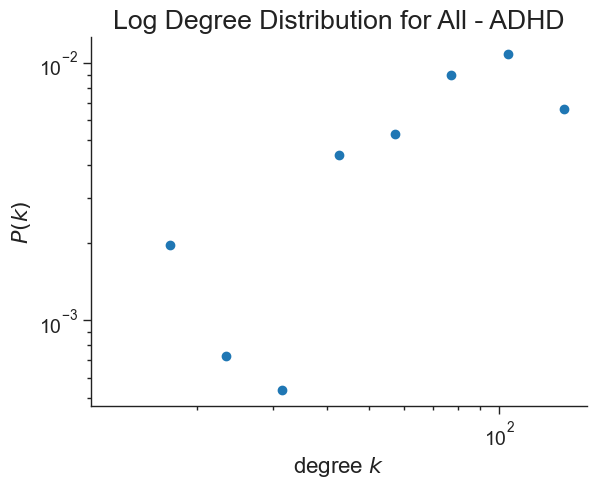

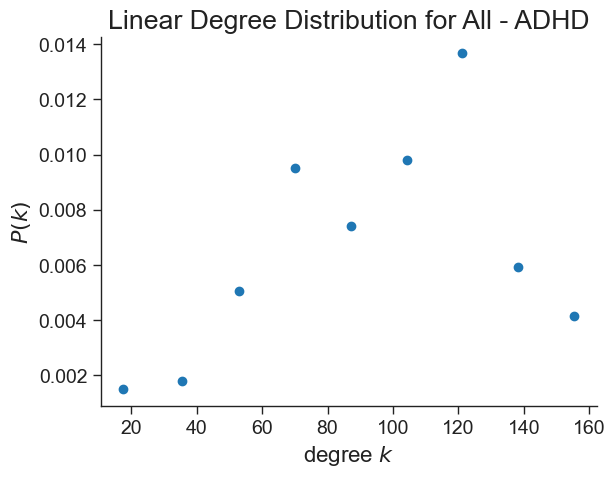

Average matrix for Control:
Graph with 198 nodes and 9751 edges
<class 'networkx.classes.graph.Graph'>


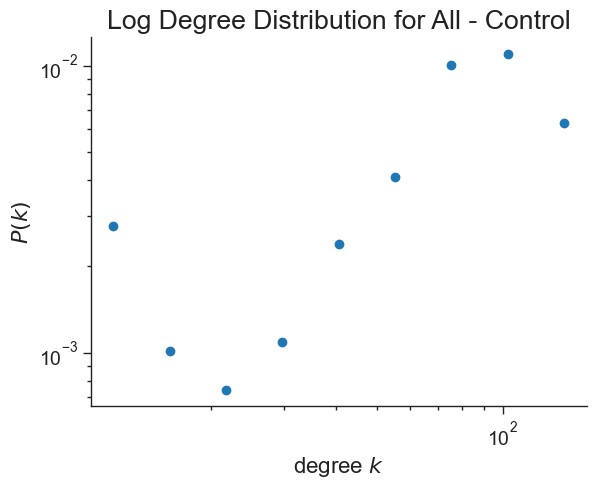

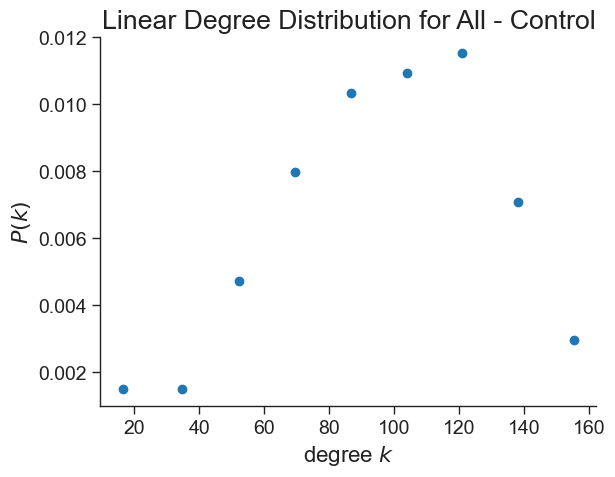

Average matrix for HFA:
Graph with 198 nodes and 9748 edges
<class 'networkx.classes.graph.Graph'>


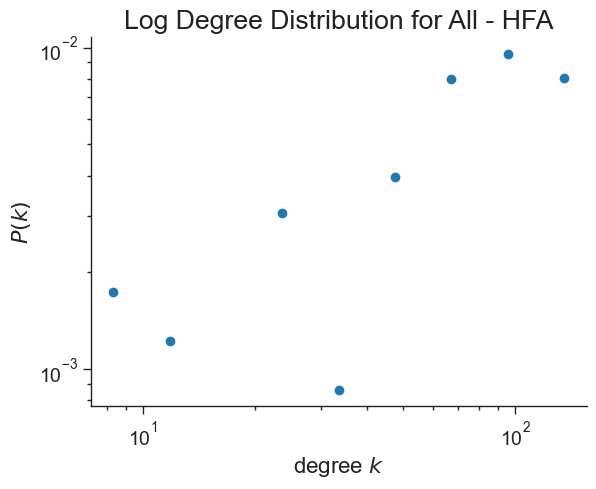

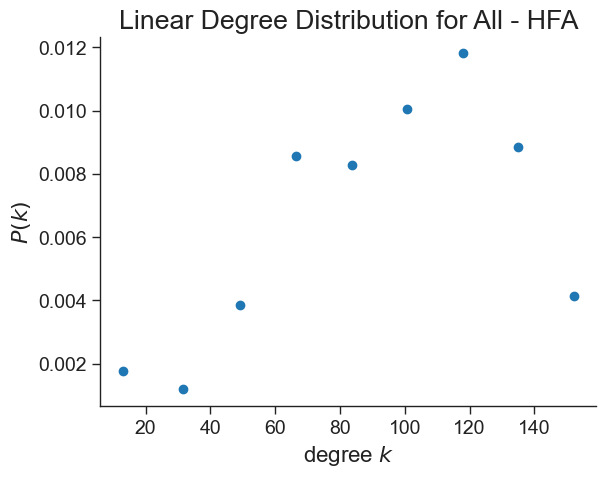

In [47]:
import numpy


for dx, mat in ave_matrices.items():
    print(f"Average matrix for {dx}:")
    print(mat)
    print(type(mat))
    if isinstance(mat, numpy.ndarray):
        print("It's a numpy array")
        graph = nx.from_numpy_array(mat)
    elif isinstance(mat, nx.Graph):
        graph = mat
    log_degree_distribution_figure("All", dx, graph=graph)
    lin_degree_distribution_figure("All", dx, graph=graph)

In [48]:
# Check if original matrices have negative correlations
for subject, _ in included_subjects[:5]:  # Check first 5
    with open(f'networkx_graphs/{subject}_graph.gpickle', 'rb') as f:
        graph = pickle.load(f)
    
    weights = [data['weight'] for u, v, data in graph.edges(data=True)]
    print(f"{subject}: Min={min(weights):.3f}, Max={max(weights):.3f}, "
          f"Neg edges={sum(1 for w in weights if w < 0)}/{len(weights)}")

sub-004: Min=-0.934, Max=0.953, Neg edges=2969/19503
sub-006: Min=-0.655, Max=0.931, Neg edges=2778/19503
sub-007: Min=-0.647, Max=0.938, Neg edges=2206/19503
sub-008: Min=-0.520, Max=0.921, Neg edges=1110/19503
sub-010: Min=-0.582, Max=0.900, Neg edges=3805/19503


# Average CC

In [117]:
ave_CCs = {}
neg_dx_Gs = {}
pos_dx_Gs = {}
for dx, G in ave_matrices.items():
    # Split graph into positive and negative
    pos_edges = [(u, v, data) for u, v, data in G.edges(data=True) if data['weight'] > 0]
    neg_edges = [(u, v, data) for u, v, data in G.edges(data=True) if data['weight'] < 0]
    print(f"For diagnosis {dx}: Positive edges: {len(pos_edges)}, Negative edges: {len(neg_edges)}")

    # positive weights
    pos_G = nx.Graph()
    pos_G.add_nodes_from(G.nodes(data=True))
    pos_G.add_edges_from(pos_edges)

    # negative weights - absolute values
    neg_G = nx.Graph()
    neg_G.add_nodes_from(G.nodes(data=True))
    for u, v, data in neg_edges:
        neg_G.add_edge(u, v, weight=abs(data['weight']))
    
    neg_dx_Gs[dx] = neg_G
    pos_dx_Gs[dx] = pos_G
    
    # For each group matrix, calculate.
    neg_w_cc = nx.clustering(neg_G, weight='weight')
    neg_ave_CC = np.mean(list(neg_w_cc.values()))
    print(f"Average Clustering Coefficient for negative weights in {dx}: {neg_ave_CC:.4f}")
    pos_w_cc = nx.clustering(pos_G, weight='weight')
    pos_ave_CC = np.mean(list(pos_w_cc.values()))
    print(f"Average Clustering Coefficient for positive weights in {dx}: {pos_ave_CC:.4f}")
    ave_CCs[dx] = (neg_ave_CC, pos_ave_CC)

For diagnosis ADHD: Positive edges: 9749, Negative edges: 2
Average Clustering Coefficient for negative weights in ADHD: 0.0000
Average Clustering Coefficient for positive weights in ADHD: 0.1829
For diagnosis Control: Positive edges: 9744, Negative edges: 7
Average Clustering Coefficient for negative weights in Control: 0.0000
Average Clustering Coefficient for positive weights in Control: 0.1734
For diagnosis HFA: Positive edges: 9746, Negative edges: 2
Average Clustering Coefficient for negative weights in HFA: 0.0000
Average Clustering Coefficient for positive weights in HFA: 0.1817


In [118]:
ave_CCs

{'ADHD': (np.float64(0.0), np.float64(0.18292248497289418)),
 'Control': (np.float64(0.0), np.float64(0.1733567274297322)),
 'HFA': (np.float64(0.0), np.float64(0.1816634075142173))}

In [119]:
pos_dx_Gs

{'ADHD': <networkx.classes.graph.Graph at 0x27e1815e4a0>,
 'Control': <networkx.classes.graph.Graph at 0x27e095d0c20>,
 'HFA': <networkx.classes.graph.Graph at 0x27e095d2970>}

# Average Shortest Path Length

In [120]:
def get_inverted_graph(G: nx.Graph) -> nx.Graph:
    '''
    Create an inverted weight graph from the input graph.
    Each edge weight is transformed as: new_weight = (2 * max_weight) - original_weight
    Parameters:
    - G: networkx.Graph
        The input graph with weighted edges.
    Returns:
    - inverted_graph: networkx.Graph
        The graph with inverted edge weights.
    '''
    inverted_graph = nx.Graph()
    max_edge = [G[i][j]['weight'] for i,j in G.edges()]
    
    max_weight = max(max_edge)
    
    for u, v, data in G.edges(data=True):
        orig_weight = data['weight']
        new_weight = (2*max_weight) - orig_weight  # Invert weight
        inverted_graph.add_edge(u, v, weight=new_weight)
    return inverted_graph
        

In [121]:
ave_matrices

{'ADHD': <networkx.classes.graph.Graph at 0x27e076e33f0>,
 'Control': <networkx.classes.graph.Graph at 0x27e076e0de0>,
 'HFA': <networkx.classes.graph.Graph at 0x27e076e3930>}

In [122]:
ave_spl_values = {}
for dx, G in ave_matrices.items():
    # inverted_G = get_inverted_graph(G)
    # print(G,inverted_G)
    
    # Split graph into positive and negative
    pos_edges = [(u, v, data) for u, v, data in G.edges(data=True) if data['weight'] > 0]
    neg_edges = [(u, v, data) for u, v, data in G.edges(data=True) if data['weight'] < 0]
    print(f"For diagnosis {dx}: Positive edges: {len(pos_edges)}, Negative edges: {len(neg_edges)}")

    # positive weights
    pos_G = nx.Graph()
    pos_G.add_nodes_from(G.nodes(data=True))
    pos_G.add_edges_from(pos_edges)

    # negative weights - absolute values
    neg_G = nx.Graph()
    neg_G.add_nodes_from(G.nodes(data=True))
    for u, v, data in neg_edges:
        neg_G.add_edge(u, v, weight=abs(data['weight']))
    
    neg_dx_inv = get_inverted_graph(neg_G)
    pos_dx_inv = get_inverted_graph(pos_G)
    # Calculate average shortest path length
    try:
        avg_spl = nx.average_shortest_path_length(pos_dx_inv, weight='weight')
        ave_spl_values[dx] = avg_spl
        print(f"Average Shortest Path Length for positive weights of {dx}: {avg_spl:.4f}")
    except nx.NetworkXError as e:
        print(f"Error calculating average shortest path length for positive weights of {dx}: {e}") 
    try:
        ave_spl = nx.average_shortest_path_length(neg_dx_inv, weight='weight')
        # ave_spl_values[dx] = ave_spl
        print(f"Average Shortest Path Length for negative weights of {dx}: {ave_spl:.4f}")
    except nx.NetworkXError as e:
        print(f"Error calculating average shortest path length for negative weights of {dx}: {e}")
    print("")

For diagnosis ADHD: Positive edges: 9749, Negative edges: 2
Average Shortest Path Length for positive weights of ADHD: 2.2009
Error calculating average shortest path length for negative weights of ADHD: Graph is not connected.

For diagnosis Control: Positive edges: 9744, Negative edges: 7
Average Shortest Path Length for positive weights of Control: 2.2103
Error calculating average shortest path length for negative weights of Control: Graph is not connected.

For diagnosis HFA: Positive edges: 9746, Negative edges: 2
Average Shortest Path Length for positive weights of HFA: 2.2076
Error calculating average shortest path length for negative weights of HFA: Graph is not connected.



# Null Model

In [123]:
n_rand = 100

In [124]:
def get_null_model(n_rand, array):
    """
    Calculate null model metrics using strength and topology preserving randomization.
    Parameters:
    - n_rand: int
        Number of randomizations to perform.
    - array: np.ndarray
        The adjacency matrix of the graph.
    Returns:
    - ps_pt_ccs: list of float
        List of clustering coefficients from randomized graphs.
    - ps_pt_spls: list of float
        List of shortest path lengths from randomized graphs.
    """
    ps_pt_ccs = []
    ps_pt_spls = []

    # strength and topology preserving randomization
    for i in range(n_rand):
        RW, r = bct.null_model_und_sign(array, 0, 0.2)
        RW_graph = nx.from_numpy_array(RW)
        
        # clustering coefficient
        w_cc_rand = nx.average_clustering(RW_graph, weight='weight')
        ps_pt_ccs.append(w_cc_rand)
        
        # shortest path length
        inv_RW = get_inverted_graph(RW_graph)
        w_spl_rand = nx.average_shortest_path_length(inv_RW, weight='weight')
        ps_pt_spls.append(w_spl_rand)
        
    return ps_pt_ccs, ps_pt_spls

In [125]:
# def plot_boxplot(ave_w_cc, ps_pt_wDP, dx, y_label):
#     fig = plt.figure(figsize=(12,2))

#     # data = [wDP, ps_pt_wDP]
#     data = ps_pt_wDP
#     fig, ax = plt.subplots()
#     ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor='lightgray'))
#     # ax.set_xticklabels(['DP', 'PS/PT'])
#     ax.set_ylabel(y_label)
#     plt.axhline(y=ave_w_cc, color='b', linestyle='--', label=f'{dx} Avg CC')
#     # plt.ylim(0, 0.4)
#     plt.legend()
#     plt.show()

In [126]:
# for dx, values in ave_CCs.items():
#     print(f"\nDiagnosis: {dx}")
#     print(f"Positive Weights Average Clustering Coefficient: {pos_ave_CC:.4f}")

#     pos_G = pos_dx_Gs[dx]
#     pos_array = nx.to_numpy_array(pos_G)
    
#     # null models
#     pos_ps_pt_wDP_ccs, pos_ps_pt_wDP_spls = get_null_model(n_rand, pos_array)
    
#     # Plot boxplots
#     print(f"Positive Weights Clustering Coefficient Null Model:")
    # plot_boxplot(pos_ave_CC, pos_ps_pt_wDP_ccs, dx, 'Clustering Coefficient')
    # plot_boxplot(ave_spl_values[dx], pos_ps_pt_wDP_spls, dx, 'Average Shortest Path Length')

In [127]:
pos_dx_Gs

{'ADHD': <networkx.classes.graph.Graph at 0x27e1815e4a0>,
 'Control': <networkx.classes.graph.Graph at 0x27e095d0c20>,
 'HFA': <networkx.classes.graph.Graph at 0x27e095d2970>}

In [128]:
cc_nulls = {}
spl_nulls = {}
for dx, values in ave_CCs.items():
    if pos_dx_Gs.get(dx) is None:
        print(f"No positive graph for {dx}")
        break
    print(f"\nCalculating null models for positive weights of {dx}:")
    matrix = nx.to_numpy_array(pos_dx_Gs.get(dx))
    cc_nulls[dx], spl_nulls[dx] = get_null_model(n_rand, matrix)


Calculating null models for positive weights of ADHD:
Checking pos_dx_Gs[ADHD]:
  Type: <class 'networkx.classes.graph.Graph'>
  Value: Graph with 198 nodes and 9749 edges
  Number of nodes: 198
  Number of edges: 9749


c:\Users\pisis\anaconda3\envs\networks_project\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]



Calculating null models for positive weights of Control:
Checking pos_dx_Gs[Control]:
  Type: <class 'networkx.classes.graph.Graph'>
  Value: Graph with 198 nodes and 9744 edges
  Number of nodes: 198
  Number of edges: 9744

Calculating null models for positive weights of HFA:
Checking pos_dx_Gs[HFA]:
  Type: <class 'networkx.classes.graph.Graph'>
  Value: Graph with 198 nodes and 9746 edges
  Number of nodes: 198
  Number of edges: 9746


In [129]:
def plot_boxplot(ave_w_cc, ps_pt_wDP, dx, y_label, y_lim=None):
    fig = plt.figure(figsize=(6,4))

    # data = [wDP, ps_pt_wDP]
    data = [ps_pt_wDP, [ave_w_cc]]
    plt.boxplot(data, positions=[1,2])
    plt.plot(2, ave_w_cc, marker='+', color='r', markersize=15)
    
    # ax.set_xticklabels(['DP', 'PS/PT'])
    plt.ylabel(y_label)
    plt.xticks([1,2], ['PS/PT', f"{dx} Avg"])
    # plt.axhline(y=ave_w_cc, color='b', linestyle='--', label=f'{dx} Avg CC')
    if y_lim is not None:
        plt.ylim(y_lim[0], y_lim[1])
    plt.legend()
    plt.show()

In [130]:
cc_nulls

{'ADHD': [0.17200247162042434,
  0.172134723733715,
  0.17239333678474708,
  0.17216221866324577,
  0.17194731627418025,
  0.17241386123627284,
  0.1719045091452167,
  0.17209862012314747,
  0.1719884754836824,
  0.1719939193436213,
  0.1720258998874652,
  0.17227447707621946,
  0.1719944068030037,
  0.17207896320590832,
  0.17207187013614172,
  0.1718900383285322,
  0.1719316411026206,
  0.17186039119935798,
  0.17210665744752923,
  0.17218492063028779,
  0.17184490609768335,
  0.17221179829817612,
  0.17206285049259418,
  0.1720783758346601,
  0.17205254319886193,
  0.17173676237317892,
  0.1720186544116778,
  0.17203396651616448,
  0.17190333330796626,
  0.17189294113163406,
  0.172232314244814,
  0.17224087270828603,
  0.17237188230872236,
  0.17185182333213014,
  0.17222027090628786,
  0.17209659433927785,
  0.1719518427490287,
  0.1720367384037599,
  0.17210698735209498,
  0.1724573575460398,
  0.172044692779676,
  0.17215602897088877,
  0.17215497225763762,
  0.1721720613821537,

In [131]:
spl_nulls

{'ADHD': [2.110217618053514,
  2.1086263564573176,
  2.112153763852033,
  2.116616271861464,
  2.1079029116352377,
  2.1137275590443307,
  2.114556600750556,
  2.1131133566641638,
  2.1058042815527216,
  2.108326731358653,
  2.113221743516507,
  2.115199793511485,
  2.1103213681635014,
  2.1161271350232354,
  2.1116954005944764,
  2.108859995792982,
  2.1159408180071586,
  2.1089965590542623,
  2.1188925677964936,
  2.109926589427636,
  2.1105869166781024,
  2.1171858294858534,
  2.108849307504545,
  2.114427460028218,
  2.113700959839087,
  2.1031118680631202,
  2.1101355270414817,
  2.1124256082601387,
  2.112808711853807,
  2.1112133329927514,
  2.113747195633588,
  2.112688481184424,
  2.110333686151498,
  2.108945645291905,
  2.111777378347433,
  2.109997103348676,
  2.1083316482811116,
  2.110153818992325,
  2.1133280346775343,
  2.11346605522587,
  2.1099924941284662,
  2.108217176616824,
  2.1111355183602942,
  2.112923951290427,
  2.108214925431037,
  2.110370654697011,
  2.11


Diagnosis: ADHD
Positive Weights Average Clustering Coefficient: 0.1829
Positive Weights Average Shortest Path Length: 2.2009
Null model CC mean: 0.1720723067039804
Null model SPL mean: 2.1117544325558284
Positive Weights Clustering Coefficient Null Model:


C:\Users\pisis\AppData\Local\Temp\ipykernel_18648\1708468879.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


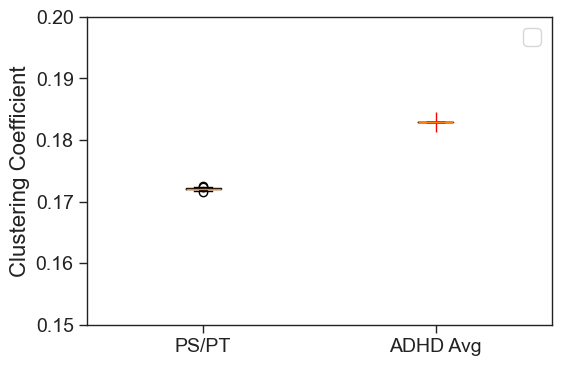

C:\Users\pisis\AppData\Local\Temp\ipykernel_18648\1708468879.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


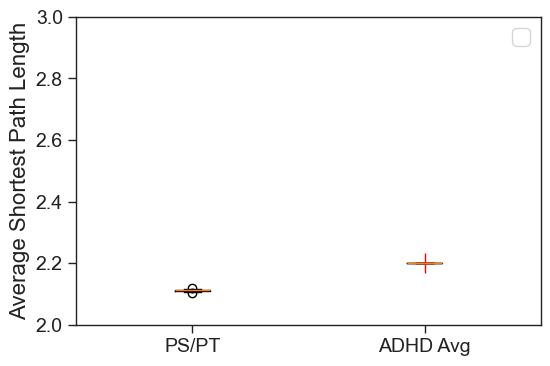

C:\Users\pisis\AppData\Local\Temp\ipykernel_18648\1708468879.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



Diagnosis: Control
Positive Weights Average Clustering Coefficient: 0.1734
Positive Weights Average Shortest Path Length: 2.2103
Null model CC mean: 0.16272834237146808
Null model SPL mean: 2.120337560052208
Positive Weights Clustering Coefficient Null Model:


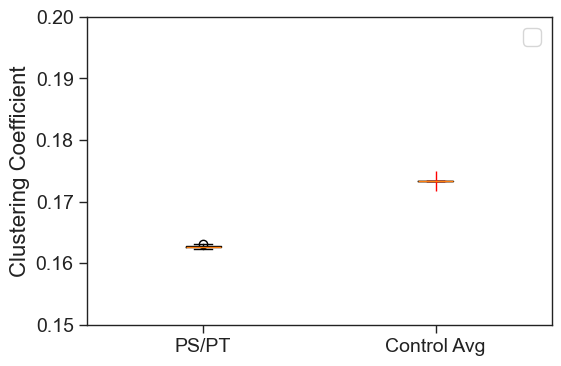

C:\Users\pisis\AppData\Local\Temp\ipykernel_18648\1708468879.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


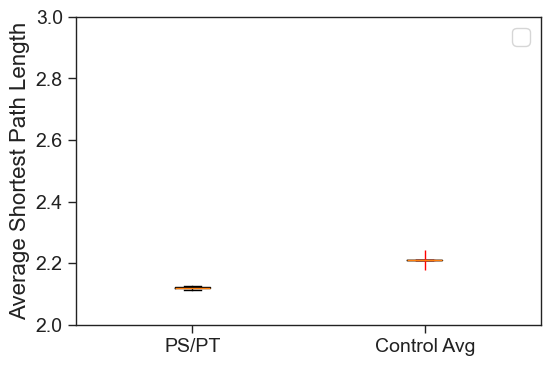

C:\Users\pisis\AppData\Local\Temp\ipykernel_18648\1708468879.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()



Diagnosis: HFA
Positive Weights Average Clustering Coefficient: 0.1817
Positive Weights Average Shortest Path Length: 2.2076
Null model CC mean: 0.17177209817200803
Null model SPL mean: 2.1280605820067358
Positive Weights Clustering Coefficient Null Model:


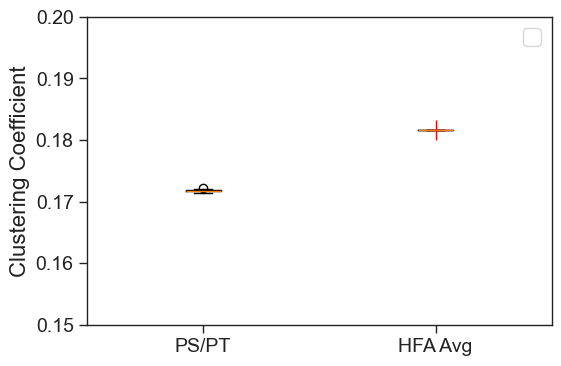

C:\Users\pisis\AppData\Local\Temp\ipykernel_18648\1708468879.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


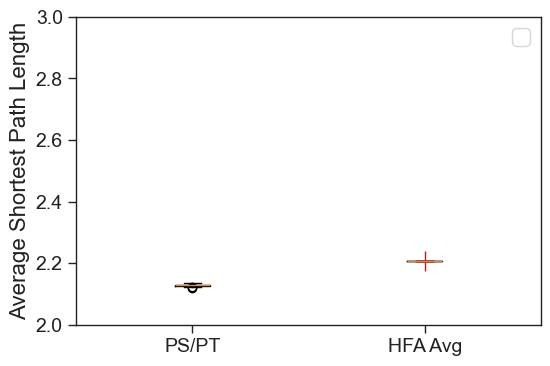

In [132]:
for dx, values in ave_CCs.items():
    pos_ave_CC = values[1]
    pos_ave_spl = ave_spl_values[dx]
    print(f"\nDiagnosis: {dx}")
    print(f"Positive Weights Average Clustering Coefficient: {pos_ave_CC:.4f}")
    print(f"Positive Weights Average Shortest Path Length: {pos_ave_spl:.4f}")

    pos_G = pos_dx_Gs[dx]
    pos_array = nx.to_numpy_array(pos_G)
    
    # null models
    # pos_ps_pt_wDP_ccs, pos_ps_pt_wDP_spls = get_null_model(n_rand, pos_array)
    pos_ps_pt_wDP_ccs = cc_nulls[dx]
    pos_ps_pt_wDP_spls = spl_nulls[dx]
    print(f"Null model CC mean: {np.mean(pos_ps_pt_wDP_ccs)}")
    print(f"Null model SPL mean: {np.mean(pos_ps_pt_wDP_spls)}")
    
    
    # Plot boxplots
    print(f"Positive Weights Clustering Coefficient Null Model:")
    plot_boxplot(pos_ave_CC, pos_ps_pt_wDP_ccs, dx, 'Clustering Coefficient', (0.15,0.20))
    plot_boxplot(pos_ave_spl, pos_ps_pt_wDP_spls, dx, 'Average Shortest Path Length', (2,3))

# Create Edge and Node Files
## Yeo 2011
Craddock is on MNI152, need another MNI142 network with image associated?
https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_atlas_comparison.html
https://nilearn.github.io/stable/manipulating_images/manipulating_images.html

Cortical parcellation estimated by intrinsic functional connectivity. https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation_Yeo2011. Accessed: 2025-11-26.
Yeo BT, Krienen FM, Sepulcre J, Sabuncu MR, Lashkari D, Hollinshead M, Roffman JL, Smoller JW, Zollei L., Polimeni JR, Fischl B, Liu H, Buckner RL. The organization of the human cerebral cortex estimated by intrinsic functional connectivity. J Neurophysiol 106(3):1125-65, 2011.

## Get network atlases

In [133]:
from nilearn.datasets import fetch_atlas_yeo_2011
import nibabel as nib # TODO: lookup what nib is
from nilearn.image import resample_to_img
import os

yeo = fetch_atlas_yeo_2011(n_networks=7, thickness = "thick")
# path
yeo_img = yeo.maps

craddock_img = nib.load('cc200_roi_atlas.nii.gz')
craddock_data = craddock_img.get_fdata().astype(int) # load craddock atlas

resampled = resample_to_img(yeo_img, craddock_img, interpolation='nearest')
resampled_data = resampled.get_fdata().astype(int)

[fetch_atlas_yeo_2011] Dataset found in C:\Users\pisis\nilearn_data\yeo_2011


C:\Users\pisis\AppData\Local\Temp\ipykernel_18648\2497587667.py:13: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  resampled = resample_to_img(yeo_img, craddock_img, interpolation='nearest')
C:\Users\pisis\AppData\Local\Temp\ipykernel_18648\2497587667.py:13: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  resampled = resample_to_img(yeo_img, craddock_img, interpolation='nearest')


In [134]:
# Cell: get labels/name of Yeo networks
yeo_labels = yeo.labels

print("Yeo 2011 Network Labels:")
for i, label in enumerate(yeo_labels):
    print(f"{i}: {label}")

Yeo 2011 Network Labels:
0: Background
1: 7Networks_1
2: 7Networks_2
3: 7Networks_3
4: 7Networks_4
5: 7Networks_5
6: 7Networks_6
7: 7Networks_7


1 - Visual
2 - somatomotor
3- dorsalattention
4- ventralattention
5 - Limbic
6 - Frontoparietal
7 - default mode

In [135]:
def triplet_to_var(str):
    '''
    Convert a triplet string "(x; y; z)" in the cc200 roi labels csv to variables.
    '''
    str = str.strip()
    str = str.strip('()')
    x_str, y_str, z_str = str.split(';')
    try:
        x = float(x_str)
        y = float(y_str)
        z = float(z_str)
    except Exception:
        print(f"Error converting triplet string to variables: {str}")
        x, y, z = None, None, None
        
    return x, y, z

In [136]:
cc_labels = pd.read_csv('SupportingInfo\\CC200_ROI_labels.csv')
cc_labels.head()

,ROI number,volume,center of mass,Dosenbach,AAL,Eickhoff-Zilles,Talairach-Tournoux,Harvard-Oxford
0,1,162,(-39.6;-85.4;1.4),"[""None"": 0.91]","[""Occipital_Mid_L"": 0.81][""Occipital_Inf_L"": 0...","[""Left Middle Occipital Gyrus"": 0.70][""Left In...","[""Left Middle Occipital Gyrus"": 0.69][""Left In...","[""Left Lateral Occipital Cortex; inferior divi..."
1,2,269,(-49.7;-60.8;23.2),"[""None"": 0.94]","[""Angular_L"": 0.49][""Temporal_Mid_L"": 0.45]","[""Left Middle Temporal Gyrus"": 0.69][""Left Ang...","[""Left Middle Temporal Gyrus"": 0.57][""Left Sup...","[""Left Angular Gyrus"": 0.46][""Left Lateral Occ..."
2,3,284,(13.3;-64.4;24.0),"[""None"": 0.93]","[""Precuneus_R"": 0.47][""Cuneus_R"": 0.31][""Calca...","[""Right Calcarine Gyrus"": 0.38][""Right Precune...","[""Right Precuneus"": 0.56][""Right Posterior Cin...","[""Right Precuneous Cortex"": 0.65][""Right Cunea..."
3,4,243,(-36.6;-13.9;-2.3),"[""None"": 0.92]","[""Temporal_Sup_L"": 0.33][""Putamen_L"": 0.28][""I...","[""Left Superior Temporal Gyrus"": 0.39][""Left I...","[""Left Insula"": 0.29][""Left Lentiform Nucleus""...","[""Left Putamen"": 0.33][""Left Insular Cortex"": ..."
4,5,222,(-6.8;45.7;7.8),"[""None"": 0.86]","[""Cingulum_Ant_L"": 0.66][""Frontal_Sup_Medial_L...","[""Left Anterior Cingulate Cortex"": 0.59][""Left...","[""Left Medial Frontal Gyrus"": 0.59][""Left Ante...","[""Left Paracingulate Gyrus"": 0.62][""Left Cingu..."


Can get the X, Y, Z for the ROIs and labels

In [137]:
cc_labels.columns

Index(['ROI number', ' volume', ' center of mass', 'Dosenbach', 'AAL',
       'Eickhoff-Zilles', 'Talairach-Tournoux', 'Harvard-Oxford'],
      dtype='object')

In [138]:
cc_labels=cc_labels.rename(columns={
    'ROI number': 'roi',
    " volume": "volume",
    " center of mass": "center_of_mass"
})

In [154]:
import re
def parse_label(str):
    """
    Parse Harvard-Oxford label string and return the label with highest probability.
    Example: ["Occipital_Mid_L": 0.81]["Occipital_Inf_L": 0.19] -> "Occipital_Mid_L"
    """
    # regular expression to extract the network number from the label
    # ex: ["Occipital_Mid_L": 0.81]["Occipital_Inf_L": 0.19] 
    pattern = r'\["([A-Za-z0-9_\s;,\-\(\)\']+)": ([0-9.]+)\]'
    matches = re.findall(pattern, str)
    
    if not matches:
        return "Unknown"
    
    # Get the label with the highest probability
    best_label, best_prob = max(matches, key=lambda x: float(x[1]))
    
    # Clean up the label (remove spaces, special chars for file compatibility)
    clean_label = best_label.replace(' ', '_').replace(';', '_').replace('(', '').replace(')', '').replace("'", '')
    
    return clean_label

In [155]:
#Cell: assign Yeo network based on roi
id_to_name = {
    0: "Unknown",
    1: "Visual",
    2: "Somatomotor",
    3: "DorsalAttention",
    4: "VentralAttention",
    5: "Limbic",
    6: "Frontoparietal",
    7: "DefaultMode",
}
def get_yeo_labels_for_craddock(roi):
    global resampled_data, craddock_data, id_to_name
    mask = craddock_data == roi # Get craddock atlas for the roi
    if not np.any(mask):
        id = 0
    else:
        # get corresponding yeo labels for this roi
        yeo_labels = resampled_data[mask]
        yeo_labels = yeo_labels[yeo_labels != 0] # remove 0s (don't think these are labeled)
        if len(yeo_labels) == 0:
            id = 0
        else: # get most common yeo label
            id = np.bincount(yeo_labels).argmax()
    name = id_to_name.get(id, "Unknown")
    return id, name
    
    

.node: X, Y, Z, node, size, label
.edge: adjacency matrix
gephi node: id, module, degree, label
gephi edge: source, target, weight

In [156]:
def get_coord_and_ho_label(roi, metadf):
    row = metadf.loc[roi-1]
    if row['roi'] != roi:
        print(f"Warning: ROI mismatch for {roi}")
    x, y, z = triplet_to_var(row['center_of_mass'])
    ho_label = parse_label(row['Harvard-Oxford'])
    return (x, y, z), ho_label

In [159]:
def create_node_edge_files(dx, cc_labels, graph: nx.Graph):
    rows = []

    for roi in range(1,201):
        if roi not in graph.nodes():
            print(f"ROI {roi} not in graph nodes for {dx}. Skipping.")
            continue
        (x,y,z), ho_label = get_coord_and_ho_label(roi, cc_labels)
        if ho_label is None:
            print(f"Could not parse Harvard-Oxford label for ROI {roi}. Setting to 'Unknown'.")
            ho_label = "Unknown"
        yeo_id, yeo_name = get_yeo_labels_for_craddock(roi)
        degree = graph.degree[roi-1]  # Assuming 0-indexed nodes
        rows.append({
            'roi': roi,
            'x': x,
            'y': y,
            'z': z,
            'Harvard-Oxford': ho_label,
            'Degree': degree,
            'Yeo_ID': yeo_id,
            'Yeo_Name': yeo_name
        })
        

    craddock_metadata = pd.DataFrame(rows)
    node_file_name = f'node_info_{inclusion_cutoff}_{dx}'
    edge_file_name = f'edge_info_{inclusion_cutoff}_{dx}'
    
    # BrainNet Viewer format: X Y Z Color Size Label (6 columns, space or tab separated)
    bnv_df = craddock_metadata[['x', 'y', 'z', 'Yeo_ID', 'Degree', 'Harvard-Oxford']]
    # Save without index, without header, tab-separated, no trailing delimiter
    bnv_df.to_csv(f'bnv_{node_file_name}.node', index=False, header=False, sep=' ')
    print(f"Saved BNV node file: bnv_{node_file_name}.node")
    
    # Edge file: just the adjacency matrix
    bnv_edges = nx.to_numpy_array(graph)
    np.savetxt(f'bnv_{edge_file_name}.edge', bnv_edges, fmt='%.6f')
    print(f"Saved BNV edge file: bnv_{edge_file_name}.edge")
    
    # Gephi files
    gephi_df = craddock_metadata[['roi', 'Yeo_ID', 'Degree', 'Harvard-Oxford']]
    gephi_df.to_csv(f'gephi_{node_file_name}.csv', index=False)
    print(f"Saved Gephi node file: gephi_{node_file_name}.csv")
    gephi_edges = nx.to_pandas_edgelist(graph)
    gephi_edges.to_csv(f'gephi_{edge_file_name}.csv', index=False)
    print(f"Saved Gephi edge file: gephi_{edge_file_name}.csv")

In [160]:
for dx, graph in ave_matrices.items():
    create_node_edge_files(dx, cc_labels, graph)

ROI 198 not in graph nodes for ADHD. Skipping.
ROI 199 not in graph nodes for ADHD. Skipping.
ROI 200 not in graph nodes for ADHD. Skipping.
Saved BNV node file: bnv_node_info_30_ADHD.node
Saved BNV edge file: bnv_edge_info_30_ADHD.edge
Saved Gephi node file: gephi_node_info_30_ADHD.csv
Saved Gephi edge file: gephi_edge_info_30_ADHD.csv
ROI 198 not in graph nodes for Control. Skipping.
ROI 199 not in graph nodes for Control. Skipping.
ROI 200 not in graph nodes for Control. Skipping.
Saved BNV node file: bnv_node_info_30_Control.node
Saved BNV edge file: bnv_edge_info_30_Control.edge
Saved Gephi node file: gephi_node_info_30_Control.csv
Saved Gephi edge file: gephi_edge_info_30_Control.csv
ROI 198 not in graph nodes for Control. Skipping.
ROI 199 not in graph nodes for Control. Skipping.
ROI 200 not in graph nodes for Control. Skipping.
Saved BNV node file: bnv_node_info_30_Control.node
Saved BNV edge file: bnv_edge_info_30_Control.edge
Saved Gephi node file: gephi_node_info_30_Control